In [1]:
import os, shutil, pathlib
import keras
from keras import layers
import numpy as np
import tensorflow as tf
from keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

In [2]:
original_dir = pathlib.Path('C:/Users/KSY/Desktop/Codes/AI/Ch_08/data/train/')
new_base_dir = pathlib.Path('C:/Users/KSY/Desktop/Codes/AI/Ch_08/cats_vs_dogs_small')

In [3]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train", # 아래 있는 디렉터리를 class로 가정
    image_size=(180, 180),
    batch_size=32)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation", # 아래 있는 디렉터리를 class로 가정
    image_size=(180, 180),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test", # 아래 있는 디렉터리를 class로 가정
    image_size=(180, 180),
    color_mode='rgb',
    crop_to_aspect_ratio=False,
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [4]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

In [5]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

# 분리 합성곱의 가정인 특성 채널은 대체적으로 독립적이다 라는 가정은 RGB 이미지에는 맞지 않음
# 컬러 채널은 매우 높은 상관관계를 가짐
# 이 모델의 첫 번째 층은 일반적인 Conv2D
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512] :
    residual = x
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same', use_bias=False)(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same', use_bias=False)(x)
    
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    residual = layers.Conv2D(size, 1, strides=2, padding='same', use_bias=False)(residual)
    x = layers.add([x, residual])

# 원래는 Dense 층 이전에 Flatten 층을 사용
# 여기에서는 GlobalAveragePooling2D층을 사용
x = layers.GlobalAveragePooling2D()(x)

# 원래 모델과 마찬기지로 규제를 위해 드롭아웃 층을 사용
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 180, 180, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 180, 180, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 176, 176, 32  2400        ['rescaling[0][0]']          

In [7]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [8]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 21s 221ms/step - loss: 0.7030 - accuracy: 0.5570 - val_loss: 0.7026 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 14s 221ms/step - loss: 0.6616 - accuracy: 0.5895 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 14s 226ms/step - loss: 0.6416 - accuracy: 0.6315 - val_loss: 0.7010 - val_accuracy: 0.5000
Epoch 4/100
63/63 [==============================] - 14s 223ms/step - loss: 0.6218 - accuracy: 0.6405 - val_loss: 0.7624 - val_accuracy: 0.5000
Epoch 5/100
63/63 [==============================] - 14s 223ms/step - loss: 0.6009 - accuracy: 0.6605 - val_loss: 0.7313 - val_accuracy: 0.5000
Epoch 6/100
63/63 [==============================] - 14s 227ms/step - loss: 0.5863 - accuracy: 0.6960 - val_loss: 0.7177 - val_accuracy: 0.5030
Epoch 7/100
63/63 [==============================] - 20s 321ms/step - loss: 0.5602 - accuracy: 0.7175 - val_loss: 0.9771 - val_accuracy:

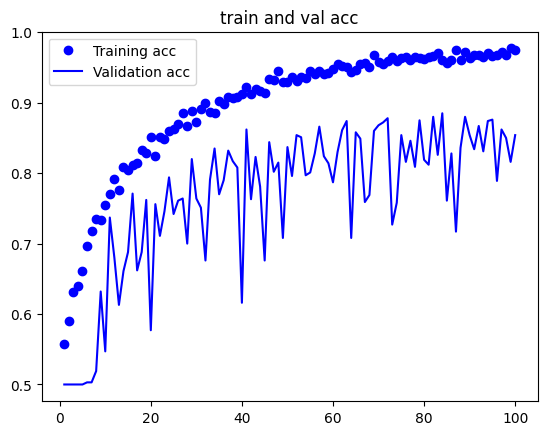

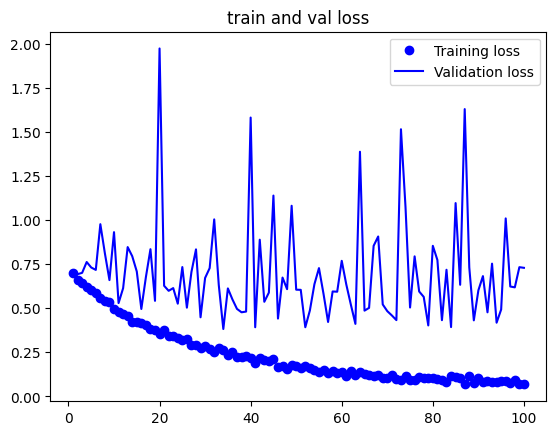

In [10]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training acc")
plt.plot(epochs, val_accuracy, "b", label="Validation acc")
plt.title("train and val acc")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("train and val loss")
plt.legend()
plt.show()

In [11]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

63/63 [==============================] - 2s 27ms/step - loss: 0.3951 - accuracy: 0.8400
테스트 정확도: 0.840
